# This will be feature selection based on the paper by kniep HC in which they get tid off all those tumors which volume is less than 125 and select the 10 lasrgest metastsis per patient. I am going to go with 15 for now. The rest would be applying the same codes as before. Only the radiomic features of the 3 classes: Melanomma, Lung, Breast (0, 1, 2).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as imbpipeline
from mrmr import mrmr_classif
from scipy import stats
from sklearn.feature_selection import f_classif
from scipy.stats import wilcoxon

In [2]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, multi_class='ovr', average=average)

from sklearn.metrics import roc_auc_score

def class_vs_rest_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)
    roc_auc_scores = {}

    for i, class_label in enumerate(lb.classes_):
        class_indices = lb.transform([class_label])[0]
        rest_indices = ~class_indices
        y_test_class = y_test_bin[:, i]
        y_test_rest = y_test_bin[:, rest_indices]
        y_pred_class = y_pred_bin[:, i]
        y_pred_rest = y_pred_bin[:, rest_indices]
        roc_auc_scores[class_label] = roc_auc_score(y_test_class, y_pred_class, multi_class='ovr', average="macro")

    return roc_auc_scores

def calculate_specificity(cm):
    num_classes = cm.shape[0]
    specificity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        specificity[i] = 100*(tn / (tn + fp))

    return specificity

def calculate_sensitivity(cm):
    num_classes = cm.shape[0]
    sensitivity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp

        sensitivity[i] = 100*(tp / (tp + fn))

    return sensitivity


def calculate_precision(cm):
    num_classes = cm.shape[0]
    precision = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp

        precision[i] = 100*(tp / (tp + fp))

    return precision


def calculate_f1_score(cm):
    num_classes = cm.shape[0]
    f1_scores = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100

    return f1_scores

def calculate_accuracy(cm):
    num_classes = cm.shape[0]
    accuracy = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn

        accuracy[i] = 100 * ((tp + tn) / (tp + tn + fp + fn))

    return accuracy

In [3]:
df = pd.read_excel('all_patients.xlsx')
#df = df.set_index(['subjid'])
df = df.drop('number_annotations', axis = 1)
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df = df.set_index(['subjid', 'label'])
confidence = 0.95
seed = 0
df

shape_Elongation  shape_Flatness  shape_LeastAxisLength   
subjid   label                                                            
Oslo01   1              0.829356        0.682981               8.512717  \
         2              0.944143        0.900681              14.133927   
Oslo02   4              0.849295        0.841082               8.703783   
         5              0.939828        0.821847              12.093804   
Oslo03   1              0.930698        0.629604              10.914986   
...                          ...             ...                    ...   
Stan_328 1              0.810571        0.325076               8.769420   
         8              0.967496        0.597282               6.131668   
         11             0.561746        0.506390               5.004740   
         12             0.959775        0.756903               5.164755   
Stan_338 4              0.819799        0.618051               8.548537   

                shape_MajorAxisLength  shape_Maximum2DDiameterColumn   
subjid   label                                                         
Oslo01   1                  12.464063                      14.866069  \
         2                  15.692487                      17.804494   
Oslo02   4                  10.348315                      10.816654   
         5                  14.715396                      17.262677   
Oslo03   1                  17.336268                      20.615528   
...                               ...                            ...   
Stan_328 1                  26.976501                      31.384710   
         8                  10.265944                      11.661904   
         11                  9.883181                       8.246211   
         12                  6.823538                       7.615773   
Stan_338 4                  13.831433                      14.142136   

                shape_Maximum2DDiameterRow  shape_Maximum2DDiameterSlice   
subjid   label                                                             
Oslo01   1                       14.560220                     12.529964  \
         2                       19.416488                     18.681542   
Oslo02   4                       11.704700                     11.704700   
         5                       17.888544                     17.492856   
Oslo03   1                       18.439089                     19.416488   
...                                    ...                           ...   
Stan_328 1                       28.160256                     27.459060   
         8                       12.369317                     12.165525   
         11                      11.704700                     10.000000   
         12                       8.602325                      8.602325   
Stan_338 4                       15.297059                     17.204651   

                shape_Maximum3DDiameter  shape_MeshVolume   
subjid   label                                              
Oslo01   1                    15.394804        728.083333  \
         2                    19.467922       2320.625000   
Oslo02   4                    12.449900        538.666667   
         5                    18.000000       1681.250000   
Oslo03   1                    20.712315       2068.958333   
...                                 ...               ...   
Stan_328 1                    33.075671       3310.541667   
         8                    12.688578        375.166667   
         11                   12.124356        159.791667   
         12                    8.602325        149.333333   
Stan_338 4                    17.291616        821.541667   

                shape_MinorAxisLength  ...  glszm_ZoneVariance   
subjid   label                         ...                       
Oslo01   1                  10.337151  ...        3.039725e+04  \
         2                  14.815951  ...        1.935116e+05   
Oslo02   4                   8.788767  ...        2.8454

In [4]:
# we select X and y
X = df.iloc[:, :-4] #leaving the sex and age features out for now
y = df.iloc[:, -1:]
print(Counter(y.values.ravel()))

Counter({1: 321, 2: 76, 0: 41})


There is an obvious inbalane of the labes wih a great majority coming from the lung. To counter attck this inbalance we eill make use of oversampling and undersapmling techniques that have proven to be useful in literature

## mRMR

In [6]:
pipelines = {
    'rf': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                       ('clf', RandomForestClassifier(random_state=0, class_weight="balanced"))]),
    #'svc': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                        #('clf', CalibratedClassifierCV(LinearSVC(multi_class='ovr', random_state=0, class_weight="balanced")))])
    }

param_grids = {
    'rf': {'clf__n_estimators': [100, 250, 1000, 3500]},
    #'svc': {'clf__base_estimator__C': [0.1, 1,10], 'clf__base_estimator__max_iter': [10000, 20000]}
}

cv_outer = RepeatedStratifiedKFold(n_splits=6, n_repeats=6, random_state=seed)

## f 10 + age and sex

In [7]:
df = pd.read_excel('all_patients.xlsx')
#df = df.set_index(['subjid'])
df = df.drop('number_annotations', axis = 1)
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df = df.set_index(['subjid', 'label'])

# we select X and y
X = df.iloc[:, :-4] #leaving the sex and age features out for now
y = df.iloc[:, -1:]
X_age_sex = df.iloc[:, :-1]
confidence = 0.95
seed = 0

In [9]:
pipelines = {
    'rf': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                       ('clf', RandomForestClassifier(random_state=0, class_weight="balanced"))]),
    #'svc': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                        #('clf', CalibratedClassifierCV(LinearSVC(multi_class='ovr', random_state=0, class_weight="balanced")))])
    }

param_grids = {
    'rf': {'clf__n_estimators': [100, 250, 1000, 3500]},
    #'svc': {'clf__base_estimator__C': [0.1, 1, 5, 10], 'clf__base_estimator__max_iter': [10000, 20000, 30000]}
}

cv_outer = RepeatedStratifiedKFold(n_splits=6, n_repeats=6, random_state=seed)

In [10]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': [], 'Accy_mean': [], 'Accy_CI': [], 'Accy_sd': []}

best_features_RF = []
num_classes = len(np.unique(y))
sum_confusion_matrix_rf = np.zeros((num_classes, num_classes))
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    prec = []
    f1 = []
    accy = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selected_feature_names = mrmr_classif(X_train_scal, y_train, K=10)
        additional_columns = ['Age', 'F', 'M']
        X_train_new = X_train_scal[selected_feature_names].join(X_age_sex[additional_columns])
        X_test_new = X_test_scal[selected_feature_names].join(X_age_sex[additional_columns])
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        precision = calculate_precision(cm)
        F1 = calculate_f1_score(cm)
        Accy = calculate_accuracy(cm)
        sum_confusion_matrix_rf += cm
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)
        prec.append(precision)
        f1.append(F1)
        accy.append(Accy)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            print('klkmuchacho')
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))

100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.796791268893656
Auc Score OvR {0: 0.8376623376623377, 1: 0.7344054580896685, 2: 0.8183060109289618}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.89it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6768000651017619
Auc Score OvR {0: 0.6082251082251082, 1: 0.6291423001949318, 2: 0.7930327868852459}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7542347065931972
Auc Score OvR {0: 0.867965367965368, 1: 0.6985849056603773, 2: 0.6961538461538461}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6237758049078804
Auc Score OvR {0: 0.48051948051948046, 1: 0.6363207547169811, 2: 0.7544871794871795}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6875564686885441
Auc Score OvR {0: 0.6385281385281385, 1: 0.6863207547169812, 2: 0.7378205128205128}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6713266215033693
Auc Score OvR {0: 0.6293532338308457, 1: 0.6198830409356726, 2: 0.7647435897435898}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7298709356877318
Auc Score OvR {0: 0.5595238095238095, 1: 0.7373294346978558, 2: 0.8927595628415299}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.60it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7523655069671751
Auc Score OvR {0: 0.773809523809524, 1: 0.689571150097466, 2: 0.7937158469945356}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.695233382969232
Auc Score OvR {0: 0.683982683982684, 1: 0.6773584905660377, 2: 0.7243589743589745}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6731757236474217
Auc Score OvR {0: 0.6385281385281385, 1: 0.6547169811320755, 2: 0.7262820512820513}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7241942543829335
Auc Score OvR {0: 0.6309523809523809, 1: 0.72688679245283, 2: 0.8147435897435897}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7282239275954908
Auc Score OvR {0: 0.8271144278606966, 1: 0.644736842105263, 2: 0.7128205128205128}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  7.55it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6981722154644214
Auc Score OvR {0: 0.672077922077922, 1: 0.6539961013645225, 2: 0.7684426229508197}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.92it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7199698582715551
Auc Score OvR {0: 0.7099567099567099, 1: 0.6569200779727096, 2: 0.7930327868852459}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6211017494036363
Auc Score OvR {0: 0.4956709956709957, 1: 0.6080188679245283, 2: 0.7596153846153846}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6907013845693092
Auc Score OvR {0: 0.773809523809524, 1: 0.6136792452830188, 2: 0.6846153846153846}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.18it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.8130126163145032
Auc Score OvR {0: 0.8528138528138529, 1: 0.7330188679245283, 2: 0.8532051282051282}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7164824214509996
Auc Score OvR {0: 0.6455223880597016, 1: 0.672514619883041, 2: 0.8314102564102563}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7010127052189175
Auc Score OvR {0: 0.5670995670995671, 1: 0.7251461988304093, 2: 0.8107923497267759}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7372540751890767
Auc Score OvR {0: 0.7099567099567099, 1: 0.7080896686159843, 2: 0.7937158469945356}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7000767052653845
Auc Score OvR {0: 0.7207792207792209, 1: 0.6518867924528301, 2: 0.7275641025641025}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.00it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5962769410882619
Auc Score OvR {0: 0.4426406926406926, 1: 0.5731132075471699, 2: 0.7730769230769231}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.88it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7899262163413107
Auc Score OvR {0: 0.788961038961039, 1: 0.7141509433962264, 2: 0.8666666666666667}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7580950398703737
Auc Score OvR {0: 0.8196517412935324, 1: 0.7251461988304093, 2: 0.7294871794871794}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6877837221524308
Auc Score OvR {0: 0.6569264069264069, 1: 0.6632553606237818, 2: 0.7431693989071038}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.99it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7152070785231556
Auc Score OvR {0: 0.7099567099567099, 1: 0.692495126705653, 2: 0.7431693989071038}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7009805707918915
Auc Score OvR {0: 0.7099567099567099, 1: 0.6231132075471698, 2: 0.7698717948717949}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5766063077383833
Auc Score OvR {0: 0.5595238095238095, 1: 0.5863207547169812, 2: 0.5839743589743589}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.725273625745324
Auc Score OvR {0: 0.6461038961038962, 1: 0.6797169811320756, 2: 0.85}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7680499884741833
Auc Score OvR {0: 0.7437810945273631, 1: 0.6988304093567251, 2: 0.8615384615384616}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.18it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7357231946676871
Auc Score OvR {0: 0.788961038961039, 1: 0.6832358674463939, 2: 0.7349726775956283}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.42it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7046258806756361
Auc Score OvR {0: 0.6569264069264069, 1: 0.6803118908382066, 2: 0.7766393442622951}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.17it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6360967125118068
Auc Score OvR {0: 0.5595238095238095, 1: 0.5891509433962264, 2: 0.7596153846153846}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7217887982038924
Auc Score OvR {0: 0.6948051948051948, 1: 0.6641509433962264, 2: 0.8064102564102564}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7441015483468313
Auc Score OvR {0: 0.7251082251082251, 1: 0.7174528301886793, 2: 0.7897435897435898}
klkmuchacho


100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6186353992520529
Auc Score OvR {0: 0.5087064676616916, 1: 0.5657894736842105, 2: 0.7814102564102565}
klkmuchacho


In [12]:

#acc
avg_acc = np.mean(fold_acc)
scores_rf['acc'].append(avg_acc)
scores_rf['acc'] = scores_rf['acc'][-1]
ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
scores_rf['CI_acc'].append(ci)
scores_rf['SD_acc'].append(np.std(fold_acc))

#auc_tot
avg_auc_tot = np.mean(fold_auc_tot)
scores_rf['auc_tot'].append(avg_auc_tot)
scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
scores_rf['CI_auc_tot'].append(ci)
scores_rf['SD_auc_tot'].append(np.std(fold_acc))

#auc_class
list_0 = list(d[0] for d in fold_auc_class)
list_1 = list(d[1] for d in fold_auc_class)
list_2 = list(d[2] for d in fold_auc_class)

avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores_rf['auc_class'].append(avg_auc_class)

sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores_rf['SD_auc_class'].append(sd_auc_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores_rf['CI_auc_class'].append(CI_auc_class)

#sensitivity
list_0 = list(d[0] for d in sensi)
list_1 = list(d[1] for d in sensi)
list_2 = list(d[2] for d in sensi)

avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores_rf['Sen_mean'].append(avg_sensi_class)

sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores_rf['Sen_SD'].append(sd_sensi_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores_rf['Sen_CI'].append(CI_sen_class)

#specificity
list_0 = list(d[0] for d in speci)
list_1 = list(d[1] for d in speci)
list_2 = list(d[2] for d in speci)

avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores_rf['Spe_mean'].append(avg_speci_class)
sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores_rf['Spe_sd'].append(sd_speci_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores_rf['Spe_CI'].append(CI_spe_class)

#precision
list_0 = list(d[0] for d in prec)
list_1 = list(d[1] for d in prec)
list_2 = list(d[2] for d in prec)

avg_prec_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores_rf['Pre_mean'].append(avg_prec_class)
sd_prec_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores_rf['Pre_sd'].append(sd_prec_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_pre_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores_rf['Pre_CI'].append(CI_pre_class)

#F1
list_0 = list(d[0] for d in f1)
list_1 = list(d[1] for d in f1)
list_2 = list(d[2] for d in f1)

avg_f1_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores_rf['F1_mean'].append(avg_f1_class)
sd_f1_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores_rf['F1_sd'].append(sd_f1_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_F1_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores_rf['F1_CI'].append(CI_F1_class)

###Accuracy per class
list_0 = list(d[0] for d in accy)
list_1 = list(d[1] for d in accy)
list_2 = list(d[2] for d in accy)

avg_accy_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores_rf['Accy_mean'].append(avg_accy_class)
sd_accy_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores_rf['Accy_sd'].append(sd_accy_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_accy_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores_rf['Accy_CI'].append(CI_accy_class)

In [13]:
for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

rf acc: 0.5928462709284626
rf SD_acc: [0.051621515622866425]
rf CI_acc: [(0.5751323028995573, 0.610560238957368)]
rf auc_tot: 0.7052917617352616
rf SD_auc_tot: [0.051621515622866425]
rf CI_auc_tot: [(0.6869323770036495, 0.7236511464668738)]
rf auc_class: [{0: 0.6759829101247012, 1: 0.6670767079006624, 2: 0.7728156671804213}]
rf SD_auc_class: [{0: 0.10753826975812208, 1: 0.047309640252697426, 2: 0.05819771288497565}]
rf CI_auc_class: [{0: (0.6390810592318273, 0.7128847610175751), 1: (0.6508423636590518, 0.6833110521422731), 2: (0.7528450713356294, 0.7927862630252132)}]
rf Sen_mean: [{0: 52.11640211640212, 1: 55.7545228666822, 2: 78.06267806267809}]
rf Sen_CI: [{0: (44.819421782625525, 59.413382450178716), 1: (53.23019011113611, 58.27885562222829), 2: (73.79225668706911, 82.33309943828706)}]
rf Sen_SD: [{0: 21.264641760961467, 1: 7.356334987457264, 2: 12.444734200575612}]
rf Spe_mean: [{0: 83.08017990853813, 1: 77.66081871345028, 2: 76.50045537340618}]
rf Spe_CI: [{0: (81.52373794103127,

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=sum_confusion_matrix_rf,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

In [ ]:
calculate_accuracy(sum_confusion_matrix_rf)

In [14]:
for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

rf acc: 0.5928462709284626
rf SD_acc: [0.051621515622866425]
rf CI_acc: [(0.5751323028995573, 0.610560238957368)]
rf auc_tot: 0.7052917617352616
rf SD_auc_tot: [0.051621515622866425]
rf CI_auc_tot: [(0.6869323770036495, 0.7236511464668738)]
rf auc_class: [{0: 0.6759829101247012, 1: 0.6670767079006624, 2: 0.7728156671804213}]
rf SD_auc_class: [{0: 0.10753826975812208, 1: 0.047309640252697426, 2: 0.05819771288497565}]
rf CI_auc_class: [{0: (0.6390810592318273, 0.7128847610175751), 1: (0.6508423636590518, 0.6833110521422731), 2: (0.7528450713356294, 0.7927862630252132)}]
rf Sen_mean: [{0: 52.11640211640212, 1: 55.7545228666822, 2: 78.06267806267809}]
rf Sen_CI: [{0: (44.819421782625525, 59.413382450178716), 1: (53.23019011113611, 58.27885562222829), 2: (73.79225668706911, 82.33309943828706)}]
rf Sen_SD: [{0: 21.264641760961467, 1: 7.356334987457264, 2: 12.444734200575612}]
rf Spe_mean: [{0: 83.08017990853813, 1: 77.66081871345028, 2: 76.50045537340618}]
rf Spe_CI: [{0: (81.52373794103127,

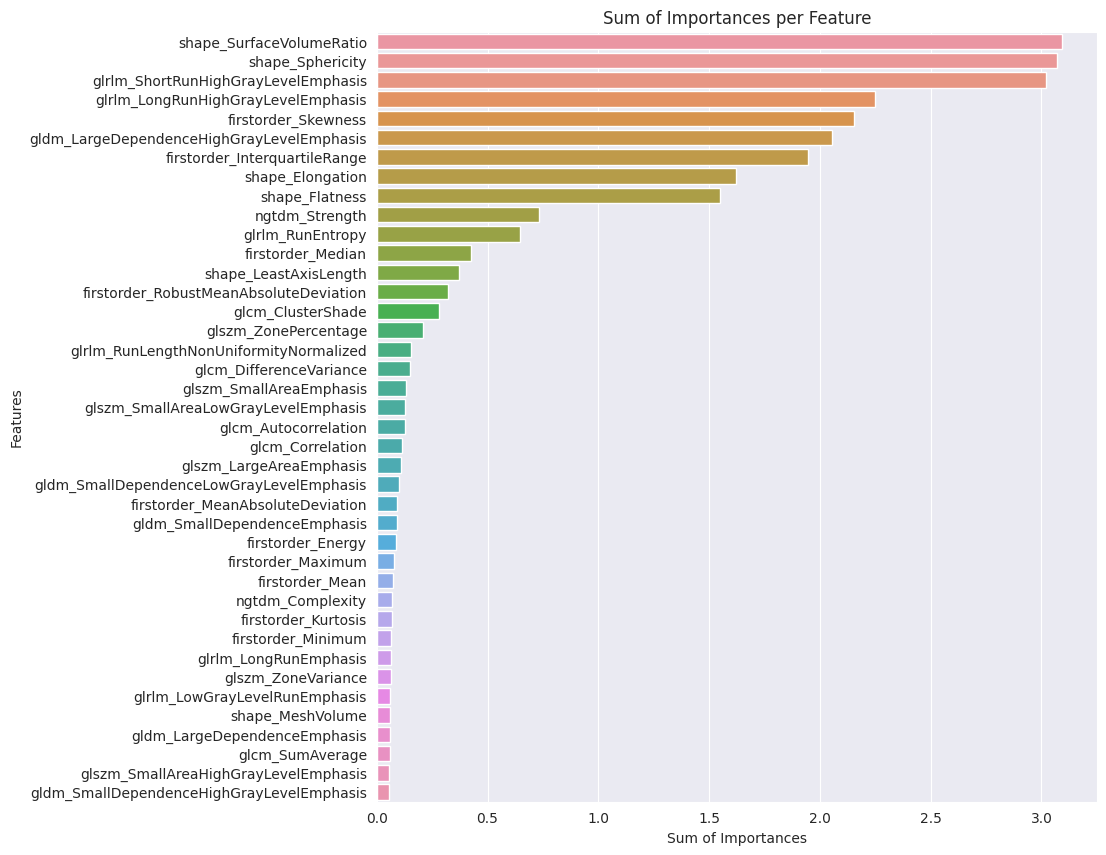

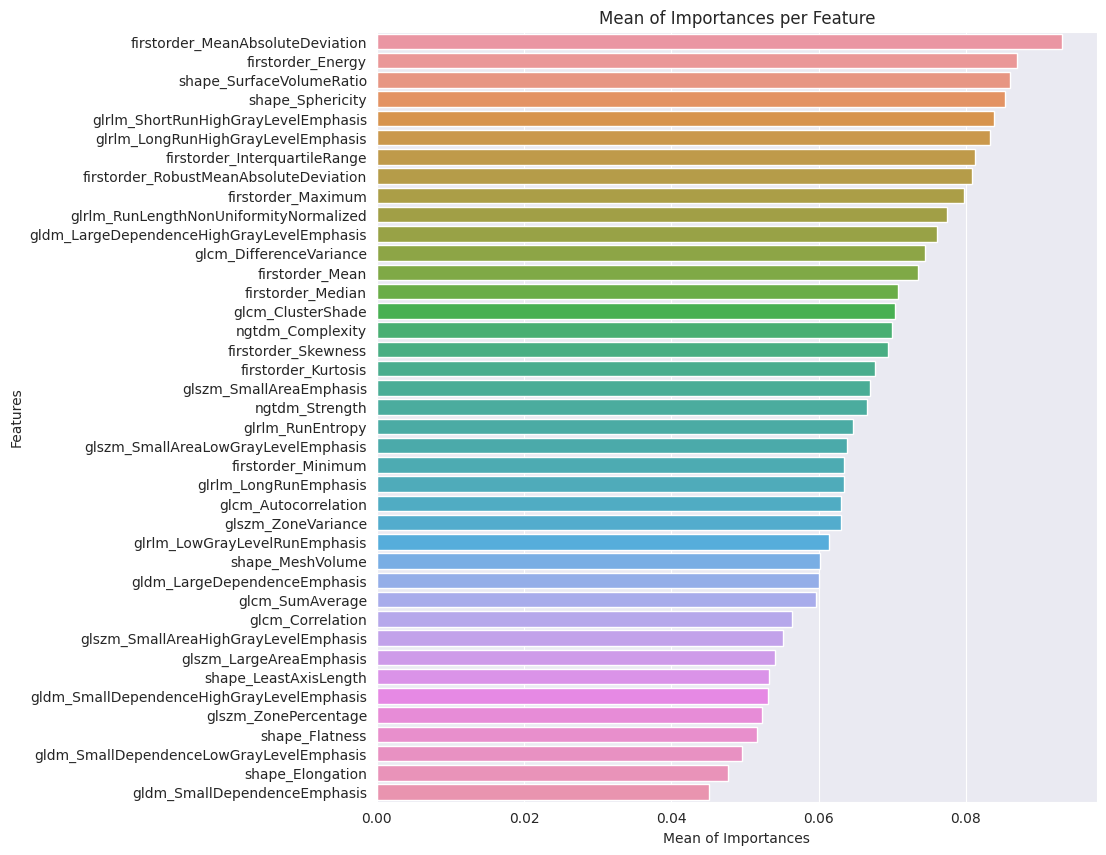

In [15]:
# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 10))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()
feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 10))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [16]:
p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_sum', p_value_sum)

p_value_sum {'shape_Sphericity': 6.116356439539216e-07, 'shape_LeastAxisLength': 0.01064046289211171, 'firstorder_Median': 1.393501890642851, 'shape_SurfaceVolumeRatio': 4.5509574982130425e-07, 'shape_Flatness': 0.00011181456045759725, 'glrlm_ShortRunHighGrayLevelEmphasis': 0.00010324935611326732, 'gldm_LargeDependenceHighGrayLevelEmphasis': 0.00020361410269482022, 'shape_Elongation': 0.0017865113103557623, 'glrlm_LongRunHighGrayLevelEmphasis': 0.00025107348356840655, 'firstorder_Skewness': 0.40480497209246974, 'glrlm_RunEntropy': 2.1627925451373675e-05, 'glrlm_LowGrayLevelRunEmphasis': 0.14570966756781048, 'firstorder_InterquartileRange': 0.8236994382341774, 'glszm_LargeAreaEmphasis': 0.012052645311024918, 'firstorder_RobustMeanAbsoluteDeviation': 0.022374523338985944, 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.0002484111902531741, 'ngtdm_Strength': 0.11563884916001879, 'glcm_Correlation': 0.26508785260565965, 'glcm_ClusterShade': 0.10955905215499293, 'glszm_ZonePercentage': 0.0021

In [17]:
print('p_value_mean', p_value_mean)

p_value_mean {'shape_Sphericity': 1.6989878998720047e-08, 'shape_LeastAxisLength': 0.00152006612744453, 'firstorder_Median': 0.2322503151071418, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'shape_Flatness': 3.727152015253242e-06, 'glrlm_ShortRunHighGrayLevelEmphasis': 2.868037669812981e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.5412630627711195e-06, 'shape_Elongation': 5.254445030458125e-05, 'glrlm_LongRunHighGrayLevelEmphasis': 9.299017909940981e-06, 'firstorder_Skewness': 0.013058224906208702, 'glrlm_RunEntropy': 2.162792545137367e-06, 'glrlm_LowGrayLevelRunEmphasis': 0.14570966756781048, 'firstorder_InterquartileRange': 0.03432080992642406, 'glszm_LargeAreaEmphasis': 0.006026322655512459, 'firstorder_RobustMeanAbsoluteDeviation': 0.005593630834746486, 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.00012420559512658704, 'ngtdm_Strength': 0.010512622650910798, 'glcm_Correlation': 0.13254392630282982, 'glcm_ClusterShade': 0.02738976303874823, 'glszm_ZonePercentage': 0.0

In [18]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Sphericity': 4.711554714493575e-08, 'shape_LeastAxisLength': 0.0020994212714331136, 'firstorder_Median': 0.08222821531204479, 'shape_SurfaceVolumeRatio': 2.8073867336962688e-08, 'shape_Flatness': 6.838313935014929e-06, 'glrlm_ShortRunHighGrayLevelEmphasis': 4.995900444062914e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 1.4152192768678566e-05, 'shape_Elongation': 0.00011119841268188059, 'glrlm_LongRunHighGrayLevelEmphasis': 2.248945715856638e-05, 'firstorder_Skewness': 0.012036381896435015, 'glrlm_RunEntropy': 5.0555858195163435e-06, 'glrlm_LowGrayLevelRunEmphasis': 0.0, 'firstorder_InterquartileRange': 0.03017039855082851, 'glszm_LargeAreaEmphasis': 0.005711078957078815, 'firstorder_RobustMeanAbsoluteDeviation': 0.0034756070357551795, 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.00010272250533577485, 'ngtdm_Strength': 0.009091510913036784, 'glcm_Correlation': 0.003610264033239413, 'glcm_ClusterShade': 0.016801946267622717, 'glszm_ZonePercentage': 0.000603885346

In [29]:
#feature_importance_mean_

best_features = sorted(feature_importance_mean_, key=lambda x: x[1], reverse=True)

best_features

['glrlm_ShortRunHighGrayLevelEmphasis',
 'gldm_LargeDependenceHighGrayLevelEmphasis',
 'glrlm_LongRunHighGrayLevelEmphasis',
 'glrlm_RunEntropy',
 'glrlm_LowGrayLevelRunEmphasis',
 'glszm_LargeAreaEmphasis',
 'gldm_SmallDependenceLowGrayLevelEmphasis',
 'glcm_Correlation',
 'glcm_ClusterShade',
 'glszm_ZonePercentage',
 'gldm_SmallDependenceEmphasis',
 'glszm_SmallAreaHighGrayLevelEmphasis',
 'glrlm_RunLengthNonUniformityNormalized',
 'glcm_SumAverage',
 'glszm_SmallAreaLowGrayLevelEmphasis',
 'glcm_Autocorrelation',
 'glszm_ZoneVariance',
 'glcm_DifferenceVariance',
 'glrlm_LongRunEmphasis',
 'gldm_LargeDependenceEmphasis',
 'glszm_SmallAreaEmphasis',
 'gldm_SmallDependenceHighGrayLevelEmphasis',
 'firstorder_Median',
 'firstorder_Skewness',
 'firstorder_InterquartileRange',
 'firstorder_RobustMeanAbsoluteDeviation',
 'firstorder_Maximum',
 'firstorder_Kurtosis',
 'firstorder_MeanAbsoluteDeviation',
 'firstorder_Minimum',
 'firstorder_Mean',
 'firstorder_Energy',
 'shape_Sphericity',


In [71]:
features_sorted

['firstorder_MeanAbsoluteDeviation',
 'firstorder_Energy',
 'shape_SurfaceVolumeRatio',
 'shape_Sphericity',
 'glrlm_ShortRunHighGrayLevelEmphasis',
 'glrlm_LongRunHighGrayLevelEmphasis',
 'firstorder_InterquartileRange',
 'firstorder_RobustMeanAbsoluteDeviation',
 'firstorder_Maximum',
 'glrlm_RunLengthNonUniformityNormalized',
 'gldm_LargeDependenceHighGrayLevelEmphasis',
 'glcm_DifferenceVariance',
 'firstorder_Mean',
 'firstorder_Median',
 'glcm_ClusterShade',
 'ngtdm_Complexity',
 'firstorder_Skewness',
 'firstorder_Kurtosis',
 'glszm_SmallAreaEmphasis',
 'ngtdm_Strength',
 'glrlm_RunEntropy',
 'glszm_SmallAreaLowGrayLevelEmphasis',
 'firstorder_Minimum',
 'glrlm_LongRunEmphasis',
 'glcm_Autocorrelation',
 'glszm_ZoneVariance',
 'glrlm_LowGrayLevelRunEmphasis',
 'shape_MeshVolume',
 'gldm_LargeDependenceEmphasis',
 'glcm_SumAverage',
 'glcm_Correlation',
 'glszm_SmallAreaHighGrayLevelEmphasis',
 'glszm_LargeAreaEmphasis',
 'shape_LeastAxisLength',
 'gldm_SmallDependenceHighGrayLev

3.469025845287277

In [63]:
import numpy as np

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] = np.append(p_value_sum[feature], value)
        else:
            p_value_sum[feature] = np.array([value])

In [64]:
p_value_sum

{'shape_Sphericity': array([7.34002481e-10, 1.58520551e-10, 4.84523262e-10, 5.97834459e-10,
        1.05739692e-11, 1.32497549e-07, 3.63588829e-09, 3.27702239e-09,
        4.82892372e-11, 4.00769244e-08, 9.05171532e-10, 5.62424740e-12,
        2.83723355e-12, 3.25908457e-09, 1.13264228e-10, 1.69279173e-11,
        5.08223957e-08, 3.98841166e-08, 1.08890109e-09, 2.58091191e-11,
        8.82150107e-09, 2.34088953e-09, 3.76557900e-08, 3.49483038e-12,
        1.54326671e-09, 3.07979427e-11, 1.97364322e-08, 1.79799172e-12,
        2.54971292e-07, 1.15376081e-10, 4.04438970e-10, 8.34652778e-10,
        5.18686731e-09, 1.00869516e-09, 6.79737314e-11, 1.26711716e-09]),
 'shape_LeastAxisLength': array([0.00183033, 0.00010713, 0.00028972, 0.00021221, 0.00639012,
        0.00017636, 0.00163459]),
 'firstorder_Median': array([0.24699043, 0.24342011, 0.3711393 , 0.21619765, 0.22721796,
        0.08853644]),
 'shape_SurfaceVolumeRatio': array([5.97084415e-09, 1.81239514e-10, 1.61232599e-08, 2.825227

In [67]:
for key, values in p_value_sum.items():
    mean = np.mean(values)
    p_value_mean[key] = mean
p_value_mean

{'shape_Sphericity': 1.6989878998720047e-08,
 'shape_LeastAxisLength': 0.00152006612744453,
 'firstorder_Median': 0.2322503151071418,
 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08,
 'shape_Flatness': 3.727152015253242e-06,
 'glrlm_ShortRunHighGrayLevelEmphasis': 2.868037669812981e-06,
 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.5412630627711195e-06,
 'shape_Elongation': 5.254445030458125e-05,
 'glrlm_LongRunHighGrayLevelEmphasis': 9.299017909940981e-06,
 'firstorder_Skewness': 0.013058224906208702,
 'glrlm_RunEntropy': 2.162792545137367e-06,
 'glrlm_LowGrayLevelRunEmphasis': 0.14570966756781048,
 'firstorder_InterquartileRange': 0.03432080992642406,
 'glszm_LargeAreaEmphasis': 0.006026322655512459,
 'firstorder_RobustMeanAbsoluteDeviation': 0.005593630834746486,
 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.00012420559512658704,
 'ngtdm_Strength': 0.010512622650910798,
 'glcm_Correlation': 0.13254392630282982,
 'glcm_ClusterShade': 0.02738976303874823,
 'glszm_ZonePercentage

In [ ]:
pene = []
for i in X.columns:
    data = [df[df['labels'] ==  0][i],
            df[df['labels'] == 1][i],
            df[df['labels'] == 2][i]]

    # performing Bartlett's test
    test_statistic, p_value = levene(data[0], data[1], data[2])
    if p_value <= 0.05:
        pene.append(i)